In [1]:
import pickle

from tqdm import tqdm

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import h5py

import processor
import xgb_model

In [2]:
data_dir = "/media/data/files/nfl_bdb_2025/data"
test_weeks = [8, 9]
proc = processor.SeparationDataProcessor(data_dir)

In [3]:
with open("xgb_model_all.pkl", "rb") as f:
    bst = pickle.load(f)

In [4]:
cache_fname = proc.cache_file_fname
with h5py.File(cache_fname, "r") as all_weeks_f:
    X = []
    y = []
    for week_num in test_weeks:
        f = all_weeks_f[f"week_{week_num}"]
        n = f["seq_arr"].shape[0]
        for idx in tqdm(range(n)):
            y.append(f["separation_arr"][idx])
            play_players_df = pd.DataFrame(
                f["play_players_arr"][idx, :, :],
                columns=xgb_model.decode(f["play_players_cols"]),
            )
            play_players_df["nflId"] = play_players_df["nflId"].astype(int)
            play_overall_df = pd.DataFrame(
                f["play_overall_arr"][idx, :, :],
                columns=xgb_model.decode(f["play_overall_cols"]),
            )
            play_overall_df["nflId"] = play_overall_df["nflId"].astype(int)
            meta_df = pd.DataFrame(
                f["meta_arr"][idx, :].reshape(1, -1),
                columns=xgb_model.decode(f["meta_cols"]),
            )
            
            pos_cols = xgb_model.get_position_cols()
        
            seq_mask = f["seq_mask"][idx, :, 0, 0].astype(int)
            idxs = np.where(seq_mask)[0]
            seq_len = idxs.max() + 1
            pos_arr = f["seq_arr"][idx, :seq_len, :, :]
            pos_df = []
            for seq_idx in range(pos_arr.shape[0]):
                seq_df = pd.DataFrame(pos_arr[seq_idx, :, :], columns=xgb_model.decode(f["seq_cols"]))
                seq_df = seq_df.drop(seq_df[seq_df["club_football"] == 1.0].index)
                seq_df["nflId"] = seq_df["nflId"].astype(int)
                
                seq_df = seq_df.merge(play_players_df, how="outer", on="nflId")
                seq_df = seq_df.merge(play_overall_df, how="outer", on=["gameId", "playId", "nflId"])
                
                seq_df["position_ord"] = np.argmax(seq_df[pos_cols].to_numpy(), axis=1)
                seq_df = seq_df.sort_values(by="position_ord")
                seq_df = seq_df[seq_df["wasTargettedReceiver"] == 1.0]
                seq_df = seq_df.merge(meta_df, how="outer", on=["gameId", "playId"])

                pos_df.append(seq_df)
            X.append(pd.concat(pos_df, axis=0))
            if idx > 25:
                break
        break            

  3%|█████▋                                                                                                                                                                       | 26/789 [00:08<04:10,  3.05it/s]


In [7]:
X[0].columns.tolist()

['gameId',
 'nflId',
 'playId',
 'frameId',
 'x',
 'y',
 's',
 'a',
 'dis',
 'o',
 'dir',
 'club_ARI',
 'club_ATL',
 'club_BAL',
 'club_BUF',
 'club_CAR',
 'club_CHI',
 'club_CIN',
 'club_CLE',
 'club_DAL',
 'club_DEN',
 'club_DET',
 'club_GB',
 'club_HOU',
 'club_IND',
 'club_JAX',
 'club_KC',
 'club_LA',
 'club_LAC',
 'club_LV',
 'club_MIA',
 'club_MIN',
 'club_NE',
 'club_NO',
 'club_NYG',
 'club_NYJ',
 'club_PHI',
 'club_PIT',
 'club_SEA',
 'club_SF',
 'club_TB',
 'club_TEN',
 'club_WAS',
 'club_football',
 'playDirection_left',
 'playDirection_right',
 'height',
 'weight',
 'position_C',
 'position_CB',
 'position_DB',
 'position_DE',
 'position_DT',
 'position_FB',
 'position_FS',
 'position_G',
 'position_ILB',
 'position_LB',
 'position_MLB',
 'position_NT',
 'position_OLB',
 'position_QB',
 'position_RB',
 'position_SS',
 'position_T',
 'position_TE',
 'position_WR',
 'wasTargettedReceiver',
 'inMotionAtBallSnap',
 'shiftSinceLineset',
 'motionSinceLineset',
 'routeRan_ANGLE',

In [5]:
idx = 0
pred_arr = []
for seq_df, true_sep in zip(X, y):
    pred_sep_arr = []
    seq_df = seq_df.drop(
        [
            "gameId", 
            "playId", 
            "nflId", 
            "frameId", 
            "position_ord",
            "inMotionAtBallSnap",
            "shiftSinceLineset",
            "motionSinceLineset",
        ], 
        axis=1,
    )
    pred_sep = bst.predict(seq_df)
    pred_arr.append(pred_sep)

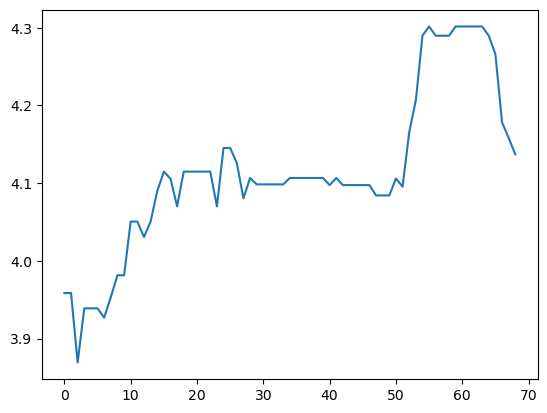

3.816084380618437


In [8]:
idx = 0

plt.figure()
plt.plot(pred_arr[idx])
plt.show()

print(y[idx])

In [ ]:
idx = 3
print(X[idx]["x"], X[idx]["y"])